In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

In [8]:
df = pd.read_csv('dataset.csv')

# Display first few rows
print("Dataset shape:", df.shape)
df.head()

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Basic statistics
df.describe()

Dataset shape: (768, 9)

Missing values per column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


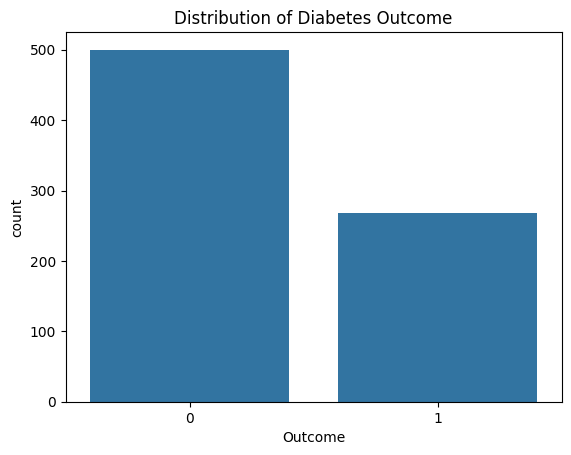

Training set size: (614, 8)
Test set size: (154, 8)


In [9]:
# Check the distribution of the target variable
sns.countplot(x='Outcome', data=df)
plt.title('Distribution of Diabetes Outcome')
plt.show()

# ## 3. Data Preprocessing

# Separate features and target variable
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

In [10]:
# ## 4. Build KNN Model with Pipeline (Scaling + Classifier)

# Create a pipeline with StandardScaler and KNN classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# ## 5. K-Fold Cross Validation

# Initialize K-Fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = []
for train_idx, val_idx in kfold.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Fit the model
    pipeline.fit(X_train_fold, y_train_fold)
    
    # Evaluate on validation fold
    y_pred = pipeline.predict(X_val_fold)
    score = accuracy_score(y_val_fold, y_pred)
    cv_scores.append(score)

print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))

Cross-validation scores: [0.6991869918699187, 0.7073170731707317, 0.7479674796747967, 0.8048780487804879, 0.7131147540983607]
Mean CV accuracy: 0.7344928695188591


In [11]:
# ## 6. Hyperparameter Tuning with GridSearchCV

# Define parameter grid for GridSearchCV
param_grid = {
    'knn__n_neighbors': range(1, 30, 2),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # 1: Manhattan distance, 2: Euclidean distance
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=kfold,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters found: {'knn__n_neighbors': 27, 'knn__p': 1, 'knn__weights': 'distance'}
Best cross-validation accuracy: 0.7686658669865387


/tmp/ipykernel_9040/866659400.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  k_results = results[results['param_knn__weights'] == 'uniform'][results['param_knn__p'] == 2]


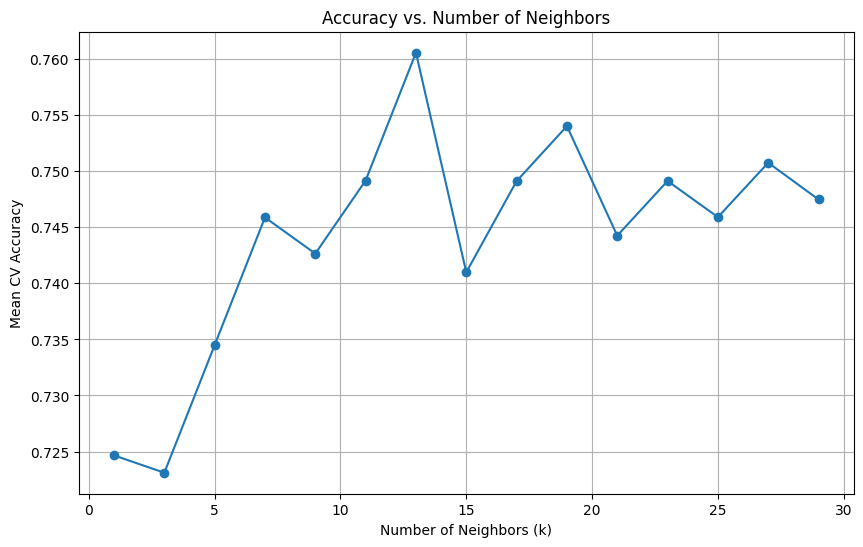

Test Accuracy: 0.7337662337662337

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       100
           1       0.67      0.48      0.56        54

    accuracy                           0.73       154
   macro avg       0.71      0.68      0.68       154
weighted avg       0.73      0.73      0.72       154



In [12]:
# Visualize the performance for different k values
results = pd.DataFrame(grid_search.cv_results_)
k_results = results[results['param_knn__weights'] == 'uniform'][results['param_knn__p'] == 2]

plt.figure(figsize=(10, 6))
plt.plot(k_results['param_knn__n_neighbors'], k_results['mean_test_score'], marker='o')
plt.title('Accuracy vs. Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean CV Accuracy')
plt.grid()
plt.show()

# %% [markdown]
# ## 7. Evaluate the Best Model on Test Set

# %%
# Get the best model from grid search
best_model = grid_search.best_estimator_

# Predict on test set
y_pred = best_model.predict(X_test)

# %%
# Evaluation metrics
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

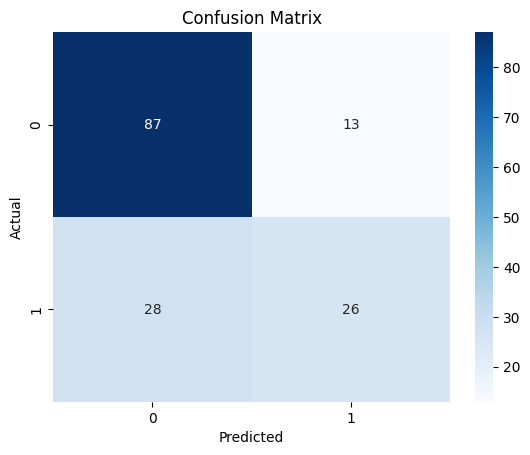

/tmp/ipykernel_9040/1721948116.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X.columns[sorted_idx])


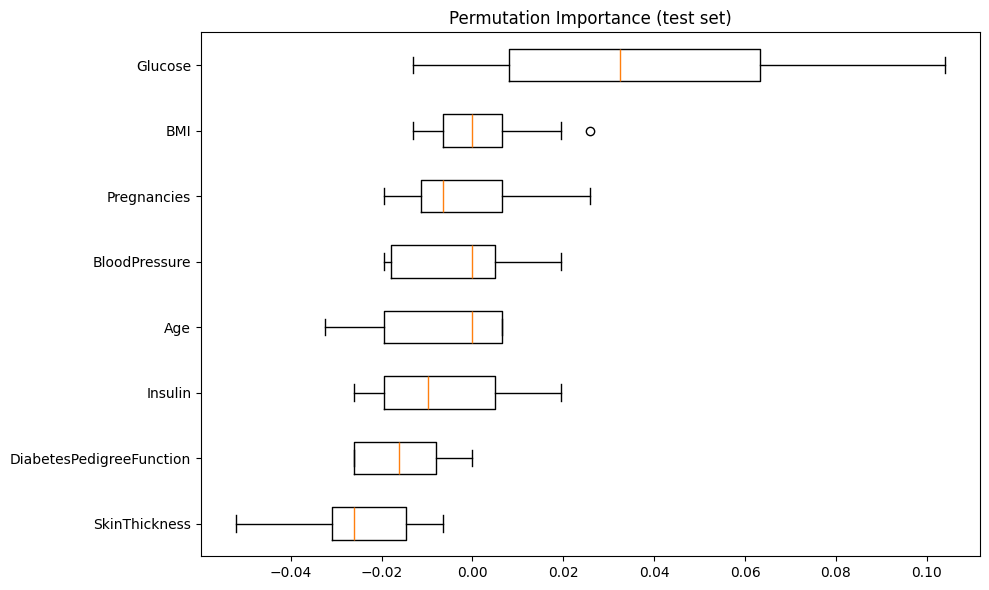

Prediction for sample data: Diabetic


/home/vikramaditya/micromamba/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [13]:


# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ## 8. Feature Importance Analysis (Permutation Importance)

# %%
from sklearn.inspection import permutation_importance

# Compute permutation importance
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)

# %%
# Sort features by importance
sorted_idx = result.importances_mean.argsort()

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X.columns[sorted_idx])
plt.title("Permutation Importance (test set)")
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 9. Final Model Deployment

# %%
# Train final model on entire dataset with best parameters
final_model = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(
        n_neighbors=grid_search.best_params_['knn__n_neighbors'],
        weights=grid_search.best_params_['knn__weights'],
        p=grid_search.best_params_['knn__p']
    ))
])

final_model.fit(X, y)

# %%
# Example prediction
sample_data = [[6, 148, 72, 35, 0, 33.6, 0.627, 50]]  # Replace with actual values
prediction = final_model.predict(sample_data)
print("Prediction for sample data:", "Diabetic" if prediction[0] == 1 else "Not Diabetic")